In [1]:
import torch
from torch import  nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 31802853.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 887733.64it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9658971.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8440641.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,hidden_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x


In [5]:
def train_loop(model, criterion, optimizer):
    epochs = 10
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for (img, _) in train_loader:
            img = img.to(device)
            img = img.reshape(-1, 28*28) 
            recon_img = model(img)
            loss = criterion(recon_img, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        epoch_loss = train_loss/len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for (img, _) in test_loader:
                img = img.to(device)
                img = img.reshape(-1, 28*28) 
                recon_img = model(img)
                loss = criterion(recon_img, img)   
                test_loss += loss.item() * img.size(0)
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)

        print(f'Epoch:{epoch+1}, Train Loss:{epoch_loss:.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses

In [6]:
def interpolate(size_of_hidden_layer, model, z1, z2, steps=10):
    model.eval()
    with torch.no_grad():

        interpolated_vectors = []
        for i in range(size_of_hidden_layer):
            interpolated_dim = torch.linspace(z1[0][i].item(), z2[0][i].item(), steps=steps)
            
            interpolated_vectors.append(interpolated_dim)

        interpolated_vectors = torch.stack(interpolated_vectors, dim=1)
        interpolated_vectors = interpolated_vectors.to(device)

        decoded_interpolations = model.decoder(interpolated_vectors)
        decoded_interpolations = decoded_interpolations.view(-1, 1, 28, 28)
    return decoded_interpolations


def interpolated_images(size_of_hidden_layer):
    for _ in range(5):

        idx1, idx2 = np.random.randint(0, len(train_data), size=2)
        image1, _ = train_data[idx1]
        image2, _ = train_data[idx2]


        image1 = image1.to(device)
        image2 = image2.to(device)


        z1 = model.encoder(image1.view(-1, 784).float()  )
        z2 = model.encoder(image2.view(-1, 784).float() )
    #     print(z1.shape)

        interpolated_images = interpolate(size_of_hidden_layer, model, z1, z2, steps=10,)

        interpolated_images = interpolated_images.cpu()

        # Display interpolated images
        plt.figure(figsize=(20, 4))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(interpolated_images[i].squeeze().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()

In [25]:
model = Autoencoder(64).to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, weight_decay = 1e-5)
#The weight_decay parameter takes care of L2 Regularisation
train_losses, test_losses = train_loop(model, criterion, optimizer)

Epoch:1, Train Loss:0.0527, Test Loss: 0.0383
Epoch:2, Train Loss:0.0325, Test Loss: 0.0290
Epoch:3, Train Loss:0.0270, Test Loss: 0.0250
Epoch:4, Train Loss:0.0246, Test Loss: 0.0236
Epoch:5, Train Loss:0.0233, Test Loss: 0.0225
Epoch:6, Train Loss:0.0218, Test Loss: 0.0211
Epoch:7, Train Loss:0.0209, Test Loss: 0.0204
Epoch:8, Train Loss:0.0203, Test Loss: 0.0199
Epoch:9, Train Loss:0.0198, Test Loss: 0.0196
Epoch:10, Train Loss:0.0195, Test Loss: 0.0193


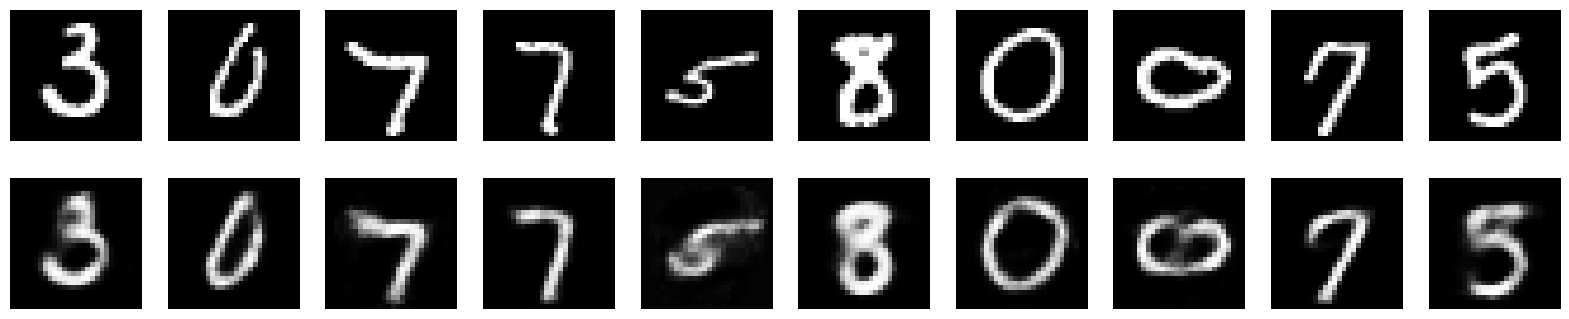

In [26]:
n = 10
plt.figure(figsize=(20,4))
model.eval()
random_indices = random.sample(range(len(train_data)), n)

with torch.no_grad():
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(train_data.data[random_indices[i]].numpy(), cmap='gray')
        plt.axis('off')
        # Reconstructed images
        img = (train_data.data[random_indices[i]].reshape(-1, 28*28 ).float() / 255.0)
        outputs = model(img.to(device))
        outputs = outputs.view(28, 28).detach().cpu().numpy()
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs, cmap='gray')
        plt.axis('off')
plt.show()

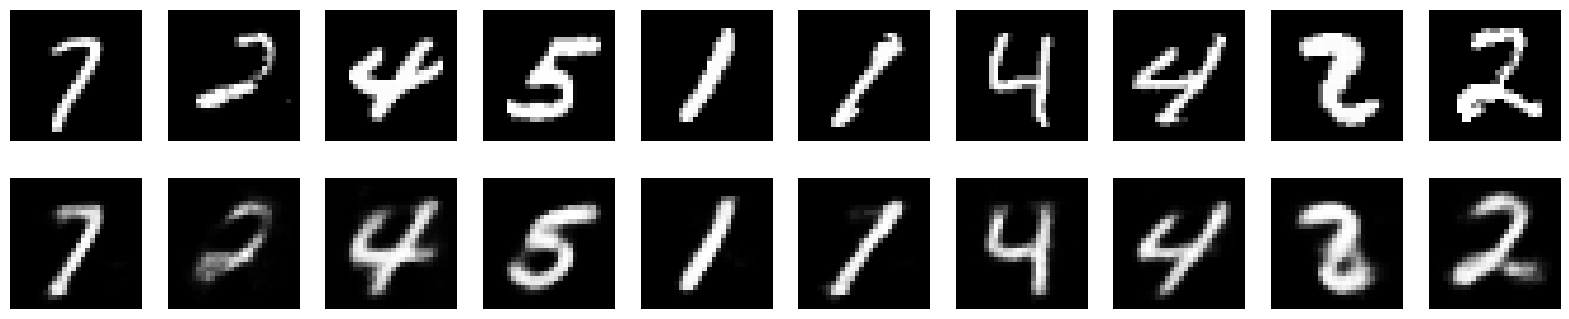

In [28]:
n = 10
plt.figure(figsize=(20, 4))
model.eval()
random_indices = random.sample(range(len(test_data)), n)
with torch.no_grad():
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(test_data.data[random_indices[i]].numpy(), cmap='gray')
        plt.axis('off')
        # Reconstructed images
        img = (test_data.data[random_indices[i]].view(-1).float() / 255.0)
        outputs = model(img.to(device))
        outputs = outputs.view(28, 28).detach().cpu().numpy()
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs, cmap='gray')
        plt.axis('off')
plt.show()

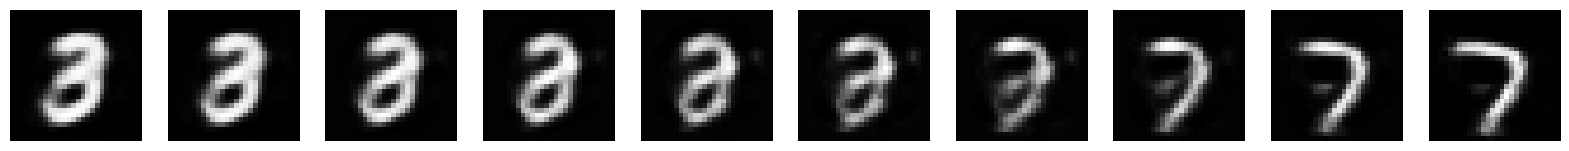

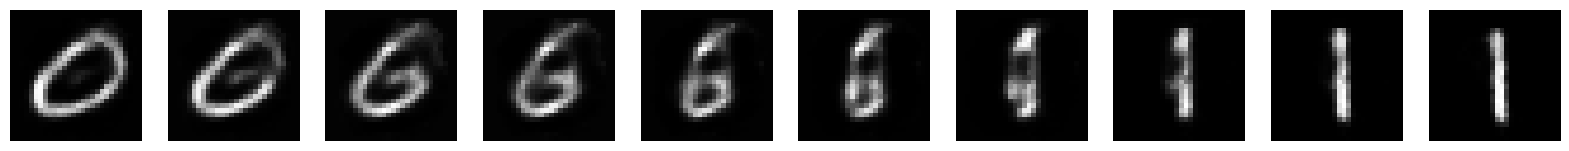

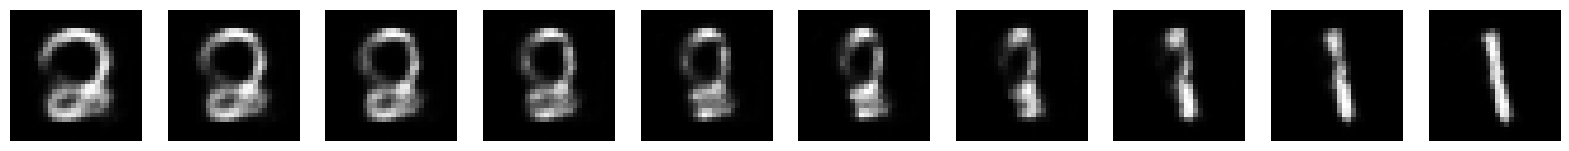

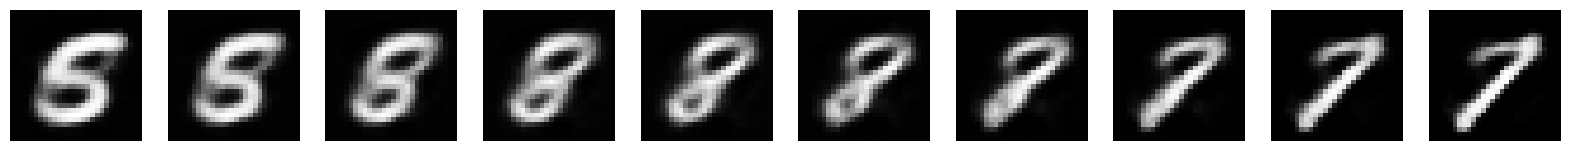

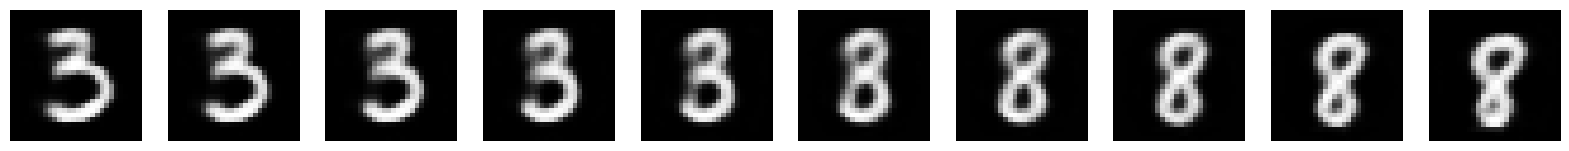

In [10]:
interpolated_images(64)

In [20]:
model = Autoencoder(32).to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, weight_decay = 1e-5)
#The weight_decay parameter takes care of L2 Regularisation
train_losses, test_losses = train_loop(model, criterion, optimizer)

Epoch:1, Train Loss:0.0531, Test Loss: 0.0380
Epoch:2, Train Loss:0.0326, Test Loss: 0.0291
Epoch:3, Train Loss:0.0265, Test Loss: 0.0239
Epoch:4, Train Loss:0.0233, Test Loss: 0.0221
Epoch:5, Train Loss:0.0220, Test Loss: 0.0211
Epoch:6, Train Loss:0.0211, Test Loss: 0.0203
Epoch:7, Train Loss:0.0204, Test Loss: 0.0198
Epoch:8, Train Loss:0.0198, Test Loss: 0.0194
Epoch:9, Train Loss:0.0191, Test Loss: 0.0187
Epoch:10, Train Loss:0.0186, Test Loss: 0.0182


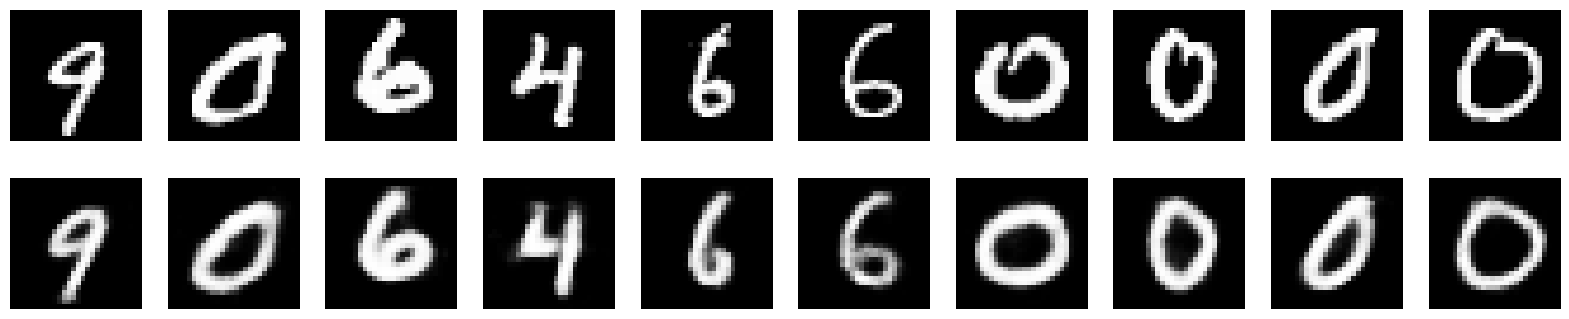

In [24]:
n = 10
plt.figure(figsize=(20, 4))
model.eval()
random_indices = random.sample(range(len(train_data)), n)
with torch.no_grad():
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(train_data.data[random_indices[i]].numpy(), cmap='gray')
        plt.axis('off')
        # Reconstructed images
        img = (train_data.data[random_indices[i]].view(-1).float() / 255.0)
        outputs = model(img.to(device))
        outputs = outputs.view(28, 28).detach().cpu().numpy()
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs, cmap='gray')
        plt.axis('off')
plt.show()

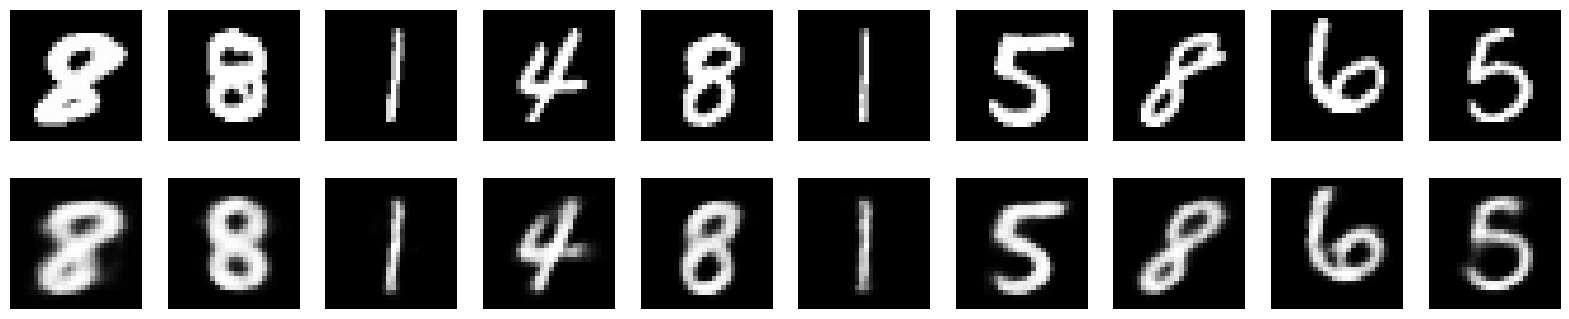

In [13]:
n = 10
plt.figure(figsize=(20, 4))
model.eval()
random_indices = random.sample(range(len(test_data)), n)
with torch.no_grad():
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(test_data.data[random_indices[i]].numpy(), cmap='gray')
        plt.axis('off')
        # Reconstructed images
        img = (test_data.data[random_indices[i]].view(-1).float() /255.0)
        outputs = model(img.to(device))
        outputs = outputs.view(28, 28).detach().cpu().numpy()
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs, cmap='gray')
        plt.axis('off')
plt.show()

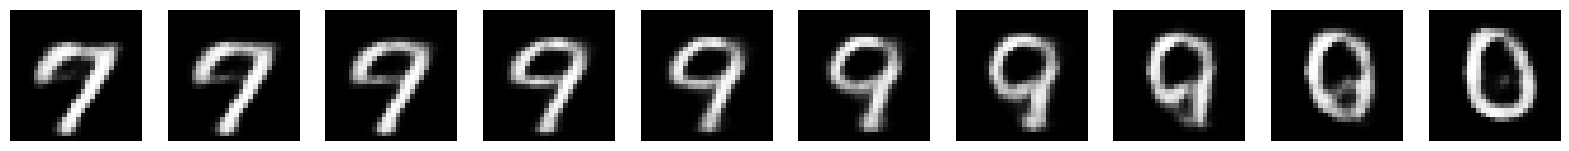

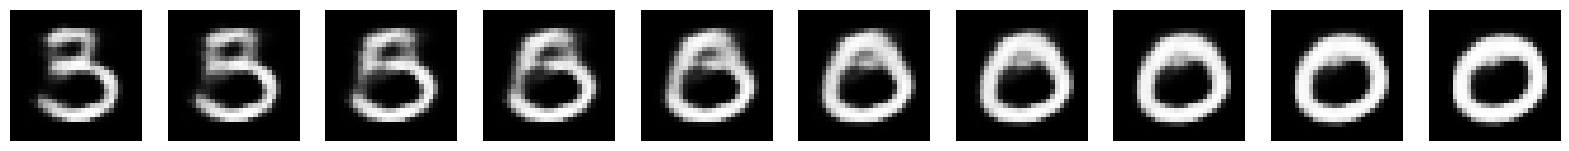

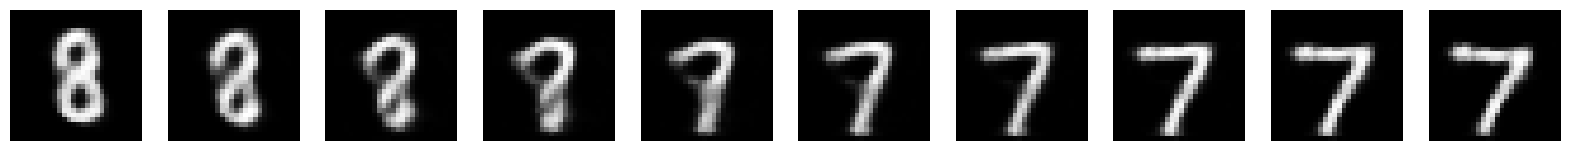

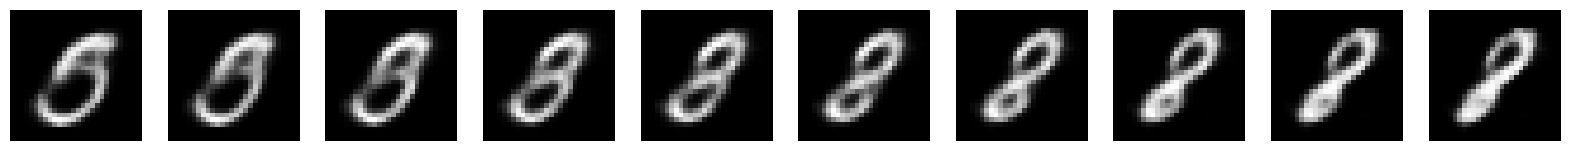

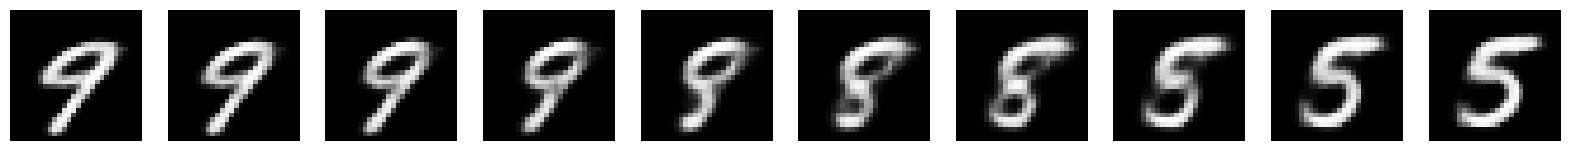

In [14]:
interpolated_images(32)

## Q2

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
            #First 16 for mean and other for variance
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        mean = encoded[:, :16]
        logVar =  encoded[:, 16:]
        #The Encoder outputs logVar instead of std deviation for numerical stability.
        std = torch.exp(0.5 * logVar)
        epsilon = torch.randn_like(std)
        z =  mean + epsilon*std
        recon_x = self.decoder(z)
        return recon_x, mean, logVar

In [16]:
def train_loop_vae(model, criterion, optimizer):
    epochs = 10
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for (img, _) in train_loader:
            img = img.to(device)
            img = img.reshape(-1, 28*28) 
            recon_img, mean, logVar = model(img)
            reconstruction_loss = criterion(recon_img, img)
            kld =  -0.5 * torch.sum(1 + logVar - mean.pow(2) - logVar.exp())
            loss = reconstruction_loss + kld
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        epoch_loss = train_loss/len(train_loader.dataset)
        print(f'Epoch:{epoch+1}, Train Loss:{epoch_loss:.4f}')

In [17]:
model = VariationalAutoencoder().to(device)
criterion = nn.BCELoss(reduction='sum') 
#Tried MSE loss but the loss is not decresing just after 1 iteration and when I generate images all the 
#images generated are same.
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3)
train_loop_vae(model, criterion, optimizer)


Epoch:1, Train Loss:11894.7240
Epoch:2, Train Loss:9321.9696
Epoch:3, Train Loss:8471.2122
Epoch:4, Train Loss:8162.3356
Epoch:5, Train Loss:8006.2219
Epoch:6, Train Loss:7896.2511
Epoch:7, Train Loss:7814.1171
Epoch:8, Train Loss:7745.5606
Epoch:9, Train Loss:7692.2644
Epoch:10, Train Loss:7609.2483


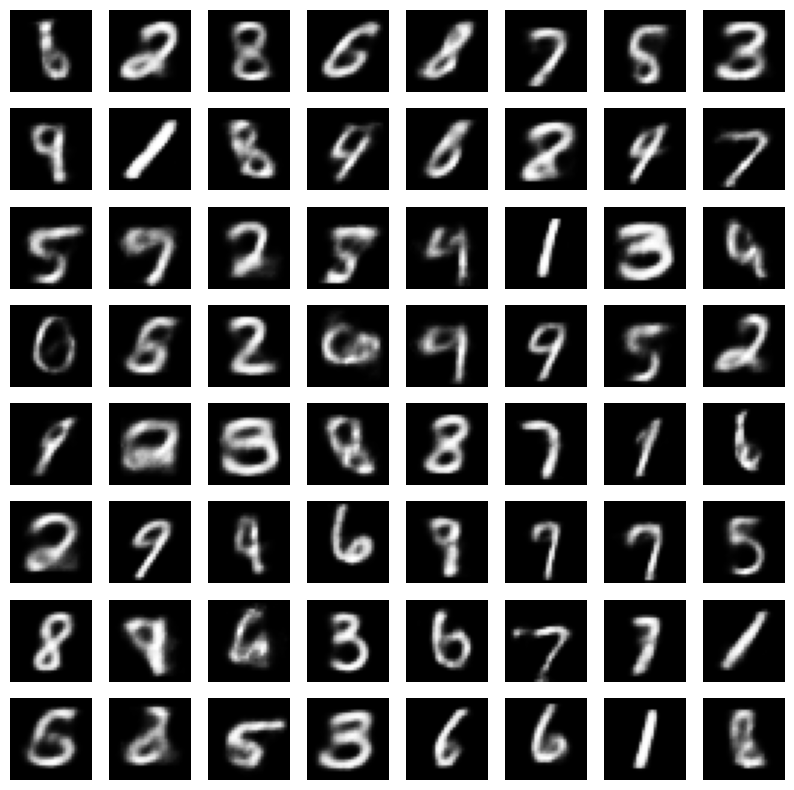

In [18]:
with torch.no_grad():
    z = torch.randn(64, 16)
    z = z.to(device)
    generated_images = []
    for i in range(64):
        generated_image = model.decoder(z[i])
        generated_images.append(generated_image.cpu().view(28, 28))
    generated_images = generated_images
    plt.figure(figsize=(10,10))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()